# Exercise 1.3

## Classification of CIFAR10 images
### Optimizers
In this exercise we will classify the images from the CIFAR10 dataset. We will use different optimizers and compare their convergence speed. First we import the libraries that we need.

In [1]:
import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

We always check that we are running on a GPU

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator


In this exercise we will classify images from the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. 
CIFAR10 has 60000 colour images of size 32x32 equally distributed in 10 classes.
* You should load this dataset (hint: it is a built-in dataset in pytorch).

In [3]:
# transform = transforms.ToTensor()
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 64
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

* Make a CNN to train on the CIFAR10 dataset

In [4]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        ## In modern python usually is writen as super().__init__()
        # Input: 3 channels (RGB), 32x32 pixels
        # Conv1: 3 input channels, 16 output channels, 3x3 kernel, 1 padding
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        # Pool1: 2x2 max pooling
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # After Pool1: 16 channels, 16x16
        
        # Conv2: 16 input channels, 32 output channels, 3x3 kernel, 1 padding
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # Pool2: 2x2 max pooling
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # After Pool2: 32 channels, 8x8
        
        # Flattening will happen in the forward pass
        # FC1: 32 * 8 * 8 = 2048 input features, 256 output features
        self.fc1 = nn.Linear(32 * 8 * 8, 256)
        
        # FC2: 256 input features, 10 output features (one for each class)
        self.fc2 = nn.Linear(256, 10)
        
        # Softmax for probability distribution
        # self.softmax = nn.Softmax(dim=1)#! Deleteing this because we add CrossEntropyLoss layer in the training loop 

    def forward(self, x):
        # Pass through Conv1, then ReLU, then Pool1
        x = self.pool1(F.relu(self.conv1(x)))
        
        # Pass through Conv2, then ReLU, then Pool2
        x = self.pool2(F.relu(self.conv2(x)))
        
        # Flatten the feature map for the FC layers
        # x.size(0) is the batch size
        x = x.view(x.size(0), -1) 
        
        # Pass through FC1, then ReLU
        x = F.relu(self.fc1(x))
        
        # Pass through FC2
        x = self.fc2(x)
        
        # Apply Softmax to get probabilities
        # x = self.softmax(x) #! Deleteing this because we add CrossEntropyLoss layer in the training loop 
        
        return x

In [5]:
model = Network()
model.to(device)
#Initialize the optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
optimizer = torch.optim.Adam(model.parameters()) #! Different optimizer

In [6]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=3):
    # def loss_fun(output, target): #! We replace this function with CrossEntropyLoss
    #     return F.cross(torch.log(output), target)
    loss_fun = nn.CrossEntropyLoss() #! Adding this

    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = loss_fun(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(loss_fun(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
    return out_dict

 * Train the network and plot make a plot of the loss and accuracy for both training and with the epoch on the x-axis

In [7]:
out_dict = train(model, optimizer, num_epochs= 10)

  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.421	 test: 1.163	 Accuracy train: 49.0%	 test: 57.6%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 1.040	 test: 1.046	 Accuracy train: 63.1%	 test: 63.1%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.888	 test: 0.933	 Accuracy train: 68.8%	 test: 67.3%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.781	 test: 0.886	 Accuracy train: 72.5%	 test: 68.8%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.685	 test: 0.877	 Accuracy train: 75.8%	 test: 70.2%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.595	 test: 0.863	 Accuracy train: 79.3%	 test: 70.9%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.512	 test: 0.890	 Accuracy train: 82.0%	 test: 70.8%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.424	 test: 0.919	 Accuracy train: 85.2%	 test: 71.4%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.358	 test: 0.987	 Accuracy train: 87.5%	 test: 71.2%


  0%|          | 0/782 [00:00<?, ?it/s]

Loss train: 0.287	 test: 1.071	 Accuracy train: 90.1%	 test: 70.6%


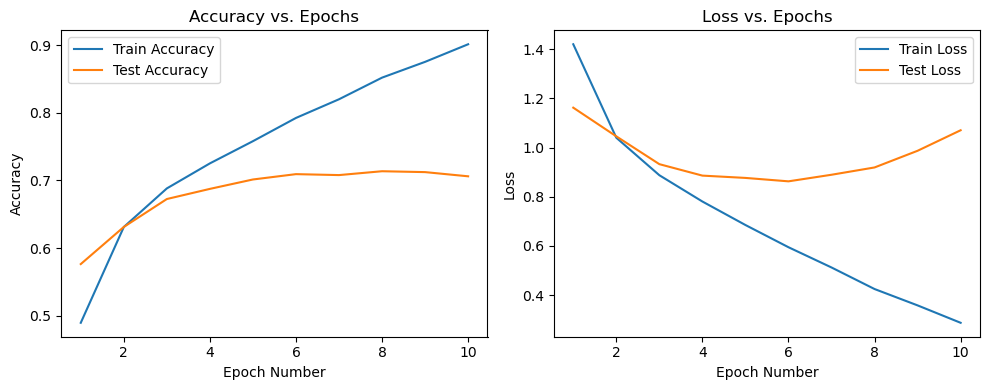

<Figure size 640x480 with 0 Axes>

In [8]:
# Get the number of epochs we ran
num_epochs = len(out_dict['train_acc'])
# Create an x-axis list [1, 2, ..., num_epochs]
epoch_axis = range(1, num_epochs + 1)

# --- Plot 1: Accuracy ---
plt.figure(figsize=(10, 4)) # Make the figure a bit wider
plt.subplot(1, 2, 1) # Create a subplot on the left
plt.plot(epoch_axis, out_dict['train_acc'], label='Train Accuracy')
plt.plot(epoch_axis, out_dict['test_acc'], label='Test Accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend() # Automatically creates a legend for the labeled plots

# --- Plot 2: Loss ---
plt.subplot(1, 2, 2) # Create a subplot on the right
plt.plot(epoch_axis, out_dict['train_loss'], label='Train Loss')
plt.plot(epoch_axis, out_dict['test_loss'], label='Test Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()

plt.tight_layout() # Cleans up the spacing between plots
plt.show() # Display the plots
plt.savefig("ADAM_10Epoch.png")

* Discuss what you see. Are you overfitting to the training data? Do you not learn anything? What can you change to do better?

* Repeat the above steps but using Adam as the optimizer. Use Pytorch's defaults parameters. Do you learn faster?
* Which optimizer works best for you?
* Plot the test and test errors for both SGD and Adam in one plot
* Try adding Batch normalisation after your convolutional layers. Does it help?

## ResNet

Now you will create and train a ResNet.
* Implement the Residual block as a network below using convolutional kernel size $3\times3$ according to the figure below
![Residual block](https://cdn-images-1.medium.com/max/800/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)

In [ ]:
class ResNetBlock(nn.Module):
    def __init__(self, n_features):
        super(ResNetBlock, self).__init__()
        ...
    def forward(self, x):
        ...
        return out

The following code is a sanity of your residual block network

In [ ]:
#Sanity test of your implementation
C = 4
res_block = ResNetBlock(C)
assert(len(res_block.state_dict())==4)
for name, weight in res_block.state_dict().items():
    weight*=0
    desired_shape = {'bias': (C,), 'weight': (C, C, 3, 3)}[name.split('.')[-1]]
    assert(desired_shape==weight.shape)
x = torch.randn(32, C, 32,32)
assert(torch.abs(res_block(x)-F.relu(x)).max()==0)
print("Passed sanity check")

We define a network that uses your `ResNetBlock`

In [ ]:
class ResNet(nn.Module):
    def __init__(self, n_in, n_features, num_res_blocks=3):
        super(ResNet, self).__init__()
        #First conv layers needs to output the desired number of features.
        conv_layers = [nn.Conv2d(n_in, n_features, kernel_size=3, stride=1, padding=1),
                       nn.ReLU()]
        for i in range(num_res_blocks):
            conv_layers.append(ResNetBlock(n_features))
        self.res_blocks = nn.Sequential(*conv_layers)
        self.fc = nn.Sequential(nn.Linear(32*32*n_features, 2048),
                                nn.ReLU(),
                                nn.Linear(2048, 512),
                                nn.ReLU(),
                                nn.Linear(512,10),
                                nn.Softmax(dim=1))
        
    def forward(self, x):
        x = self.res_blocks(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        out = self.fc(x)
        return out

Let's train our new ResNet!

In [ ]:
model = ResNet(3, 8)
model.to(device)
#Initialize the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
out_dict = train(model, optimizer)



Do you get nan loss at some point during training? 
This can be caused by the numerical instability of using softmax and log as two functions. 
* Change your network and loss to use a layer that combines the softmax log into one such as `nn.LogSoftmax`. You can also use `nn.CrossEntropyLoss` which also integrates `nn.NLLLoss`.

# ~~~~ SANDBOX

In [36]:
batch = next(iter(test_loader))
print(f"->type(batch)= {type(batch)},\n\tlen(batch)= {len(batch)}")
# print(batch)

data, labels = batch
print("#____")
print(f"type(data)= {type(data)},\n\tdata.shape() -> {data.shape},\n\tlen(data)= {len(data)}")
print("#____")
print(f"type(labels)= {type(labels)},\n\tlabels.shape() -> {labels.shape},\n\tlen(labels)= {len(labels)}")


obs_0 = data[0]
print(obs_0.shape)
obs_0.min()
obs_0.max()

obs_0.shape

->type(batch)= <class 'list'>,
	len(batch)= 2
#____
type(data)= <class 'torch.Tensor'>,
	data.shape() -> torch.Size([64, 3, 32, 32]),
	len(data)= 64
#____
type(labels)= <class 'torch.Tensor'>,
	labels.shape() -> torch.Size([64]),
	len(labels)= 64
torch.Size([3, 32, 32])


torch.Size([3, 32, 32])

In [37]:
a = np.array([[[1,2,3],[4,5,6]], [[-1,-2,-3],[-4,-5,-6]]])
print(a)

print(f"a.shape= {a.shape}")

print("#____")
a_ = a.reshape(3, -1)
print(a_)

[[[ 1  2  3]
  [ 4  5  6]]

 [[-1 -2 -3]
  [-4 -5 -6]]]
a.shape= (2, 2, 3)
#____
[[ 1  2  3  4]
 [ 5  6 -1 -2]
 [-3 -4 -5 -6]]


In [38]:
idx = torch.Tensor(np.array([2], dtype= np.int16)).int()
print(idx)
# l = torch.Tensor(np.array([1,2,3,4]))
# print(l[idx])

tensor([2], dtype=torch.int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9137255..0.8666667].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..0.9137255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92941177..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.88235295..0.78039217].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.84313726..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8901961..0.9764706]

[]


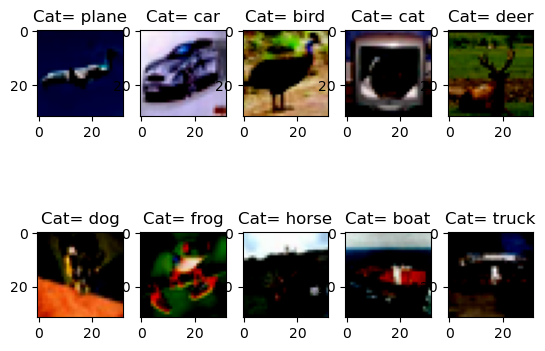

In [39]:
imgs = []
categories = list(range(0,10))
for batch_data, batch_labels in iter(train_loader):    
    for idx in range(len(batch_labels)):
        if len(categories) != 0 and batch_labels[idx] in categories:
            imgs.append((batch_data[idx], batch_labels[idx]))
            categories.remove(batch_labels[idx])
print(categories)
imgs.sort(key= lambda x : x[1])
cat_dict = {
    0 : "plane",
    1 : "car",
    2 : "bird",
    3 : "cat",
    4 : "deer",
    5 : "dog",
    6 : "frog",
    7 : "horse",
    8 : "boat",
    9 : "truck"
}
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(imgs[i][0].permute(1,2,0))
    plt.title(f"Cat= {cat_dict[imgs[i][1].cpu().item()]}")

In [41]:
import torch
import torch.nn as nn

# --- 1. Define the loss function ---
# This single object will be used for all your training steps.
criterion = nn.CrossEntropyLoss()

# --- 2. Get example data (batch size = 4, num classes = 3) ---

# Your model's raw output (logits)
# (Batch of 4 samples, 3 classes: "cat", "dog", "bird")
logits = torch.randn(4, 3, requires_grad=True)

# Your true labels (indices)
# Sample 0 is "dog" (index 1)
# Sample 1 is "cat" (index 0)
# Sample 2 is "dog" (index 1)
# Sample 3 is "bird" (index 2)
labels = torch.tensor([1, 0, 1, 2])


# --- 3. Calculate the loss ---
# Just pass the raw logits and the correct indices
loss = criterion(logits, labels)

print(loss)
# loss.backward() # This is what you'd call in your training loop

tensor(1.4221, grad_fn=<NllLossBackward0>)


In [44]:
labels

tensor([1, 0, 1, 2])

In [ ]:
# plt.plot(range(1,11), out_dict.get('train_acc'))
plt.plot(range(1,11), out_dict.get('test_acc'))
plt.legend(('Test error','Train eror'))
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')